# Ensemble methods: Tree Bagging; Random Forests; Adaboost

We talked a bit in passing about a few ensemble methods when we talked about trees etc. Let's take some time to use them! We'll go over both the sklearn implementations, and try implementing both ourselves. In the 'do it yourself' part, I'll give you a single iteration, it is your job to put it together ;)

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.datasets import load_boston
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier


# For producing decision tree diagrams.
from IPython.core.display import Image, display
from six import StringIO
import pydotplus


Today, we'll instead use the famous *boston housing data* to try out ensemble methods. We are going to make the output binary, so that we can focus on classification. We'll do regression later.

In [2]:
# load the boston housing data
boston = load_boston()
X, Y = boston.data, boston.target

# binarize the output so it is now a classification task
Y = 1 * (Y > np.median(Y))

# Shuffle the data, but make sure that the features and accompanying labels stay in sync.
np.random.seed(0)
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

# Split into train and test.
train_data, train_labels = X[:350], Y[:350]
test_data, test_labels = X[350:], Y[350:]

For the following questions, you might find this function useful to print out the tree. If you want to try a graphical way, look into this function:
http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html

The below function prints out a 'pseudocode' version of the tree, in terms of if-else statements.

In [3]:
def get_code(tree, feature_names):
        left      = tree.tree_.children_left
        right     = tree.tree_.children_right
        threshold = tree.tree_.threshold
        features  = [feature_names[i] for i in tree.tree_.feature]
        value = tree.tree_.value

        def recurse(left, right, threshold, features, node):
                if (threshold[node] != -2):
                        print("if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
                        if left[node] != -1:
                                recurse (left, right, threshold, features,left[node])
                        print("} else {")
                        if right[node] != -1:
                                recurse (left, right, threshold, features,right[node])
                        print("}")
                else:
                        print("return " + str(value[node]))

        recurse(left, right, threshold, features, 0)

# example call:
# get_code(dt, boston.feature_names)

NameError: name 'dt' is not defined

## Ensemble Methods!

Let's explore what sklearn has in terms of ensemble methods. There are two interesting ones we can use right now, adaboost and random forests. We'll start by using the sklearn ones, then try implementing random forests ourselves!

Be sure to reference the documentation at:  http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Let's start with just executing some sklearn functions:

In [4]:
dt = DecisionTreeClassifier(criterion="entropy", splitter="best", random_state=0, min_samples_split=15)
dt.fit(train_data, train_labels)

print('Accuracy (a decision tree):', dt.score(test_data, test_labels))

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(train_data, train_labels)

print('Accuracy (a random forest):', rfc.score(test_data, test_labels))

abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, learning_rate=0.1)
abc.fit(train_data, train_labels)

print('Accuracy (adaboost with decision trees):', abc.score(test_data, test_labels))

Accuracy (a decision tree): 0.8717948717948718
Accuracy (a random forest): 0.9102564102564102
Accuracy (adaboost with decision trees): 0.9102564102564102


It looks like ensemble methods do well, both do better than a single tree. Lets plot using each of the two methods:

In [5]:
get_code(dt, boston.feature_names)

if ( LSTAT <= 7.684999942779541 ) {
if ( PTRATIO <= 21.5 ) {
return [[ 0. 94.]]
} else {
return [[1. 0.]]
}
} else {
if ( LSTAT <= 14.045000076293945 ) {
if ( RM <= 6.315499782562256 ) {
if ( INDUS <= 13.360000133514404 ) {
if ( CRIM <= 0.05717500112950802 ) {
return [[14.  0.]]
} else {
if ( CRIM <= 0.5821950137615204 ) {
if ( TAX <= 404.5 ) {
if ( INDUS <= 4.2200000286102295 ) {
return [[0. 4.]]
} else {
if ( AGE <= 28.049999237060547 ) {
return [[0. 3.]]
} else {
if ( RM <= 5.92300009727478 ) {
return [[8. 0.]]
} else {
if ( AGE <= 45.39999961853027 ) {
return [[1. 5.]]
} else {
if ( B <= 395.9150085449219 ) {
return [[6. 5.]]
} else {
return [[8. 0.]]
}
}
}
}
}
} else {
return [[4. 0.]]
}
} else {
return [[7. 0.]]
}
}
} else {
if ( B <= 390.7099914550781 ) {
return [[7. 7.]]
} else {
return [[0. 6.]]
}
}
} else {
if ( TAX <= 305.5 ) {
return [[ 0. 19.]]
} else {
if ( RAD <= 5.5 ) {
return [[4. 3.]]
} else {
return [[ 1. 11.]]
}
}
}
} else {
if ( PTRATIO <= 19.450000762939453 ) {
if

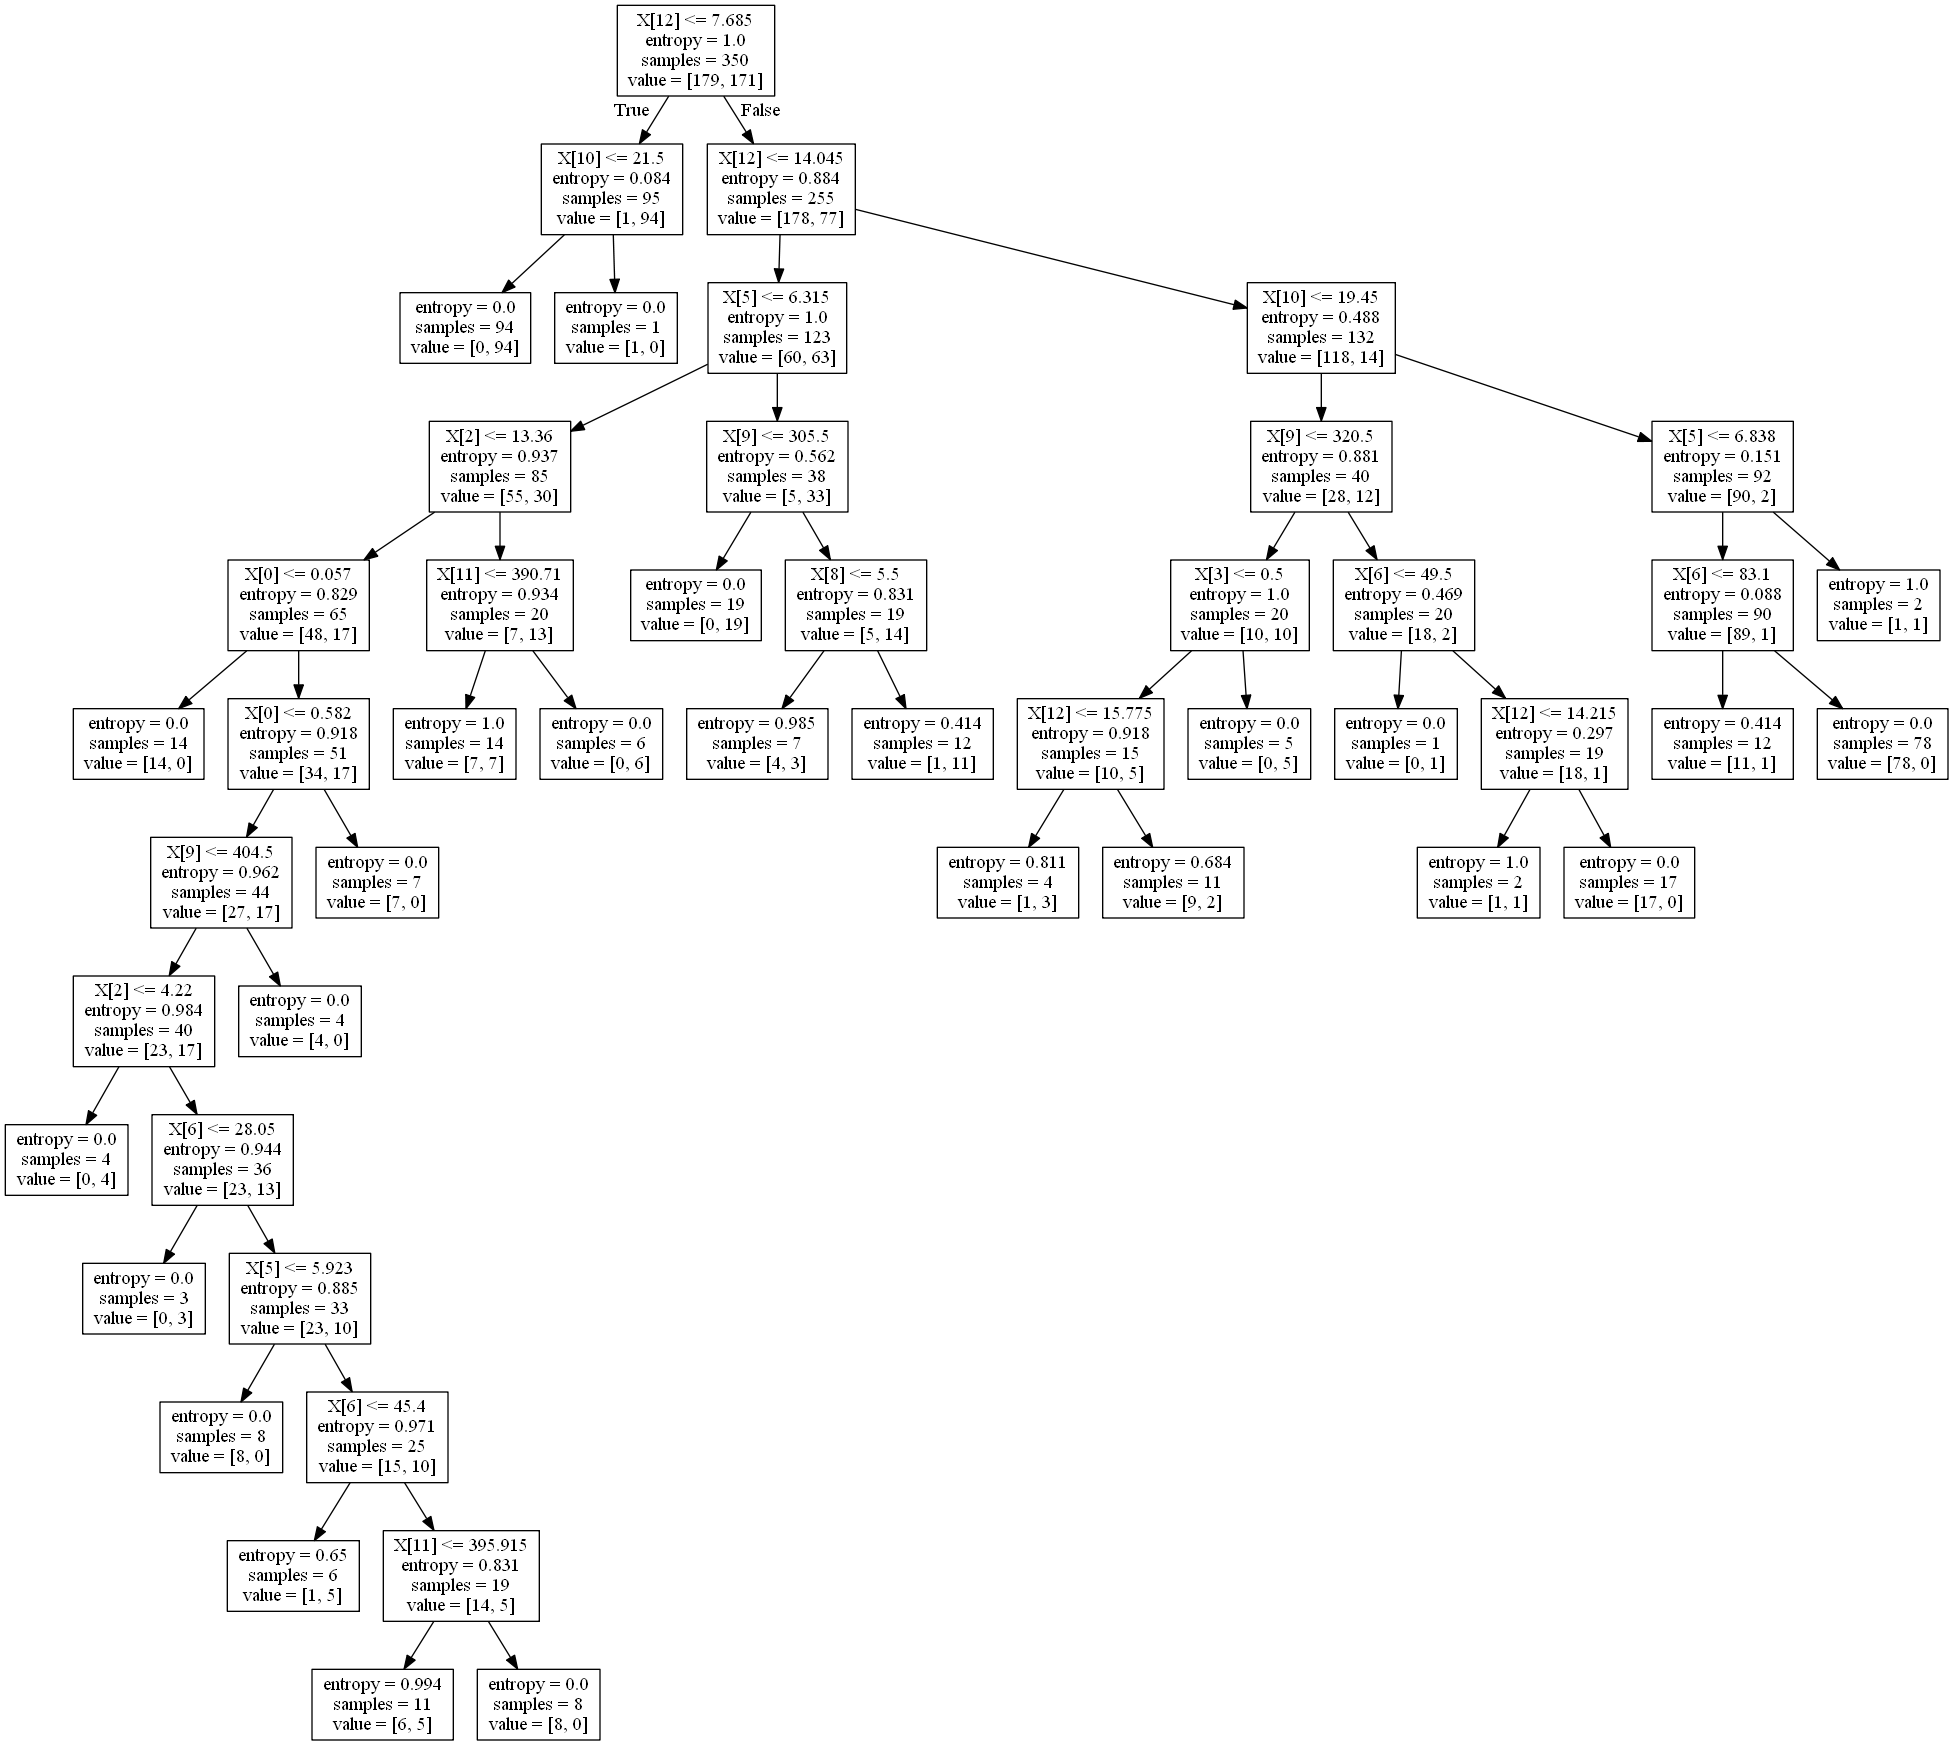

In [13]:
graph = pydotplus.graphviz.graph_from_dot_file('dot_data.dot')
graph.write_png('dot_data.png')

display(Image(filename='dot_data.png'))

Before moving on, try playing arond with some of the parameters, such as:

n_estimators in RandomForestClassifier


n_estimators and learning_rate AdaBoostClassifier

Why do the methods behave as they when you tweak the parameters?

### Random forests

Random forests are combinations of many decision trees. Let's start with a slightly simplified version: **tree bagging**. Here is a simple algorithm for tree bagging:

1. Set B (number of trees to make)
2. Repeat B times:
  1. Draw N random samples from training data, with replacement, where N is the number of training data points
  2. Fit a decision tree to this re-sampled data
  3. Store the predictions from this decision tree on the test data
3. As the final predictions on the test data, use the majority vote classification for the predictions above

Below, I've given you an implementation of a single iteration of the main loop above. Complete the algorthim by (1) adding the repeated B resampling and fitting (2) implementing step 3 above, the final predictions from tree bagging.

Once you've done that, does bagging do better than a single tree?

In [7]:
np.random.seed(1)

# the following can be replaced in a single line with:
# np.random.choice(range(n), size=n, replace=True)
# but I've given the explicit code so you can learn a bit :-)
def bs_sample_index(n):
    bootstrap_sample_index = np.random.rand(n)
    bootstrap_sample_index = np.floor(bootstrap_sample_index * n).astype("int")
    #bootstrap_sample_index = bootstrap_sample_index.astype("int")
    
    return bootstrap_sample_index

trees = 10
forest = []
threshold = 0.5


for i in range(trees):
    # a single iteration of tree bagging
    bootstrap_sample_index = bs_sample_index(train_data.shape[0])

    bs_data = train_data[bootstrap_sample_index, :]
    bs_labels = train_labels[bootstrap_sample_index]
    
    # without max_features restriction this is 'tree bagging'
    #bs_tree = DecisionTreeClassifier(criterion="entropy", splitter="best")
    
    # with max_features restriction this is 'random forest'
    bs_tree = DecisionTreeClassifier(criterion="entropy", splitter="best", max_features="sqrt")
    
    bs_tree.fit(bs_data, bs_labels)

    bs_tree_preds = bs_tree.predict(test_data)
    forest.append(bs_tree_preds)
    
prediction = 1 * (np.sum(forest,axis=0)/ len(forest) > threshold)
accuracy = sum(1 * (prediction == test_labels)) / len(test_labels)

print("Accuracy (random forest with ", trees, " trees):", accuracy)

Accuracy (random forest with  10  trees): 0.9102564102564102


Now, we are ready to do **random forests**. Random forests add the twist of subsampling features at each node. Typically, we take p' = sqrt(p) features. DecisionTreeClassifier implements with through the *max_features*, check out the documentation. A simple change to your above code should give you random forests.

Does random forests do better than tree bagging?

Note: you can also use trees, tree bagging, and random forests for regression! Now, the original data is a regression problem so just reload the data, and to do all of these ideas using trees, you need only use DecisionTreeRegressor instead of DecisionTreeClassifier; see:
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

As a bonus, try implementing trees, tree bagging, and random forests for regression.

In [8]:
np.random.seed(1)

# the following can be replaced in a single line with:
# np.random.choice(range(n), size=n, replace=True)
# but I've given the explicit code so you can learn a bit :-)
def bs_sample_index(n):
    bootstrap_sample_index = np.random.rand(n)
    bootstrap_sample_index = np.floor(bootstrap_sample_index * n).astype("int")
    #bootstrap_sample_index = bootstrap_sample_index.astype("int")
    
    return bootstrap_sample_index

trees = 20
forest = []
classification_threshold = 0.5
feature_selection_threshold = 0.1

for i in range(trees):
    # a single iteration of tree bagging
    bootstrap_sample_index = bs_sample_index(train_data.shape[0])
    sample_features = np.random.rand(train_data.shape[1]) > feature_selection_threshold

    bs_data = train_data[bootstrap_sample_index, :]
    bs_data = bs_data[:, sample_features]
    bs_labels = train_labels[bootstrap_sample_index]
    
    # without max_features restriction this is 'tree bagging'
    # bs_tree = DecisionTreeClassifier(criterion="entropy", splitter="best")
    
    # with max_features restriction this is 'random forest'
    bs_tree = DecisionTreeClassifier(criterion="entropy", splitter="best", max_features="sqrt")
    
    bs_tree.fit(bs_data, bs_labels)

    bs_tree_preds = bs_tree.predict(test_data[:,sample_features])
    forest.append(bs_tree_preds)
    
prediction = 1 * (np.sum(forest,axis=0)/ len(forest) > classification_threshold)
accuracy = sum(1 * (prediction == test_labels)) / len(test_labels)

print("Accuracy (random forest with ", trees, " trees):", accuracy)

Accuracy (random forest with  20  trees): 0.9166666666666666


## AdaBoost

Adaboost is another popular ensemble method. It operates roughly in the following way:

1. Initialize a set of weights over the data by weighting each datapoint equally. Set a number of learning rounds B
2. Do the following B times:
  1. *Train a simple classifier on the data*, using the current set of weights.
  2. *Compute the overall error rate on the **training data** *, weighted by the current set of weights, of the classifier, **save this error rate**.
  3. *Update the distribution of weights*, giving more importance to datapoints we misclassified
3. Combine the classifiers of all the loop iterations together, weighted by a function (denoted error_rate_alpha below) of their error rates.

Below, a single iteration of adaboost is implemented. 

Before extending it, check out how we update the weights. How does this emphasize errors made in the previous round?

Now, extend it so it actually does multiple learning rounds.

In [9]:
# convert labels into +/- 1; this is just how adaboost likes it :)
train_labels_pm = train_labels * 2 - 1
test_labels_pm = test_labels * 2 - 1

# initialize with equal weights on each data point
data_weights = np.ones(train_data.shape[0]).astype("float") / float(train_data.shape[0])

# set number of learing rounds
learning_rounds = 100
bdtc_predictions = []
bdtc_predictions_test = []
bdtc_predictions_test_weighted = []
error_rate_alphas = []

for l in range(learning_rounds):
    
    # here begins a single learning round:
    
    bdtc = DecisionTreeClassifier(max_depth=1)
    bdtc.fit(train_data, train_labels_pm, sample_weight=data_weights)

    # you'll need to save bdtc_predictions each iteration of the loop to do final training set predictions
    bdtc_prediction = bdtc.predict(train_data)
    bdtc_predictions.append(bdtc_prediction)

    # you'll need to save bdtc_predictions_test each iteration of the loop to do final test set predictions
    bdtc_prediction_test = bdtc.predict(test_data)
    bdtc_predictions_test.append(bdtc_predictions_test)
    
    round_accuracy = sum(1 * (bdtc_prediction_test == test_labels_pm)) / len(test_labels_pm)
    print("Accuracy (Adaboost learning round ", l+1, " ):", round_accuracy)
    
    bdtc_weighted_error_rate = np.sum(data_weights * (1 * (bdtc_prediction != train_labels_pm)).astype("float"))

    # you'll need to save error_rate_alpha each iteration of the loop to do all final predictions
    error_rate_alpha = np.log((1 - bdtc_weighted_error_rate) / bdtc_weighted_error_rate) / 2
    error_rate_alphas.append(error_rate_alpha)
    bdtc_predictions_test_weighted.append(bdtc_prediction_test * error_rate_alpha)
    
    # reweighting: how does this emphasize errors?    
    data_weights_updated = data_weights * np.exp(-1 * error_rate_alpha * bdtc_prediction * train_labels_pm)
    data_weights_updated = data_weights_updated / sum(data_weights_updated)
    data_weights = data_weights_updated

prediction = 1 * (np.sum(bdtc_predictions_test_weighted,axis=0) > 0)
accuracy = sum(1 * (prediction == test_labels)) / len(test_labels)
print("Accuracy (Adaboost with ", learning_rounds, " learning rounds):", accuracy)


Accuracy (Adaboost learning round  1  ): 0.8717948717948718
Accuracy (Adaboost learning round  2  ): 0.782051282051282
Accuracy (Adaboost learning round  3  ): 0.7051282051282052
Accuracy (Adaboost learning round  4  ): 0.4230769230769231
Accuracy (Adaboost learning round  5  ): 0.8269230769230769
Accuracy (Adaboost learning round  6  ): 0.6538461538461539
Accuracy (Adaboost learning round  7  ): 0.6858974358974359
Accuracy (Adaboost learning round  8  ): 0.5512820512820513
Accuracy (Adaboost learning round  9  ): 0.8269230769230769
Accuracy (Adaboost learning round  10  ): 0.5
Accuracy (Adaboost learning round  11  ): 0.5512820512820513
Accuracy (Adaboost learning round  12  ): 0.4935897435897436
Accuracy (Adaboost learning round  13  ): 0.5641025641025641
Accuracy (Adaboost learning round  14  ): 0.4935897435897436
Accuracy (Adaboost learning round  15  ): 0.5512820512820513
Accuracy (Adaboost learning round  16  ): 0.5512820512820513
Accuracy (Adaboost learning round  17  ): 0.55128

Note that the above algorithm is a *meta algorithm*, meaning we can use any kind of classifier, not just decision trees in the above. Try using another one. Does that change the results?

Note that the above is a bit adapted to a classification loss, we'd need to use something like L2 boosting for regression, that is beyond the scope of this notebook.